<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/.addixo/3_Data_balacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


label
0      319
1    42426
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """


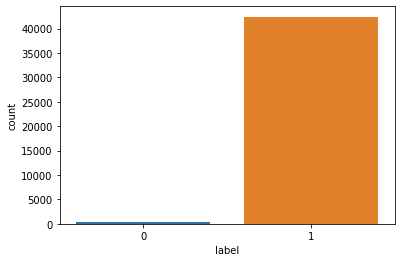

In [13]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_chosen_dataset_lasso.csv')

df.dropna(inplace = True)
df["date"] = pd.to_datetime(df["date"])
df.insert(0,'new_date',pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').astype(int))
df.drop(['date'], axis=1, inplace=True)
print(df.groupby(['label']).size())

sns.countplot(x ='label', data = df)

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop(['label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29921, 12), (29921,), (12824, 12), (12824,))

## Smote-Enn

In [15]:
print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_enn = SMOTEENN()
X_train_smote_enn_res, y_train_smote_enn_res = smote_enn.fit_resample(X_train, y_train.ravel())

print("After smote-enn: counts of label '1': {}".format(sum(y_train_smote_enn_res==1)))
print("After smote-enn: counts of label '0': {}".format(sum(y_train_smote_enn_res==0)))
X_train_smote_enn_res.shape, y_train_smote_enn_res.shape, X_test.shape, y_test.shape

Before: counts of label '1': 29692
Before: counts of label '0': 229 

After smote-enn: counts of label '1': 19263
After smote-enn: counts of label '0': 23581


((42844, 12), (42844,), (12824, 12), (12824,))

## Smote-TomerLink

In [16]:
print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_tl = SMOTETomek()
X_train_smote_tl_res, y_train_smote_tl_res = smote_tl.fit_resample(X_train, y_train.ravel())

print("After smote-tl: counts of label '1': {}".format(sum(y_train_smote_tl_res==1)))
print("After smote-tl: counts of label '0': {}".format(sum(y_train_smote_tl_res==0)))
X_train_smote_tl_res.shape, y_train_smote_tl_res.shape, X_test.shape, y_test.shape

Before: counts of label '1': 29692
Before: counts of label '0': 229 

After smote-tl: counts of label '1': 25873
After smote-tl: counts of label '0': 25873


((51746, 12), (51746,), (12824, 12), (12824,))

## KNN classification for comparaison

In [17]:
smote_enn_df = {'x_train': X_train_smote_enn_res, 'y_train': y_train_smote_enn_res}
smote_tl_df = {'x_train': X_train_smote_tl_res, 'y_train': y_train_smote_tl_res}

all_dfs = [smote_enn_df, smote_tl_df]

0 95.66437928883343
roc 0.8928162574385285
_______________________________________________
1 91.32096069868996
roc 0.9293496850077658
_______________________________________________
{'dataset': 0, 'accuracy': 95.66437928883343, 'best_params': ['euclidean', 5, 'distance']}
              precision    recall  f1-score   support

           0       0.06      0.82      0.12        90
           1       1.00      0.91      0.95     12734

    accuracy                           0.91     12824
   macro avg       0.53      0.87      0.54     12824
weighted avg       0.99      0.91      0.95     12824



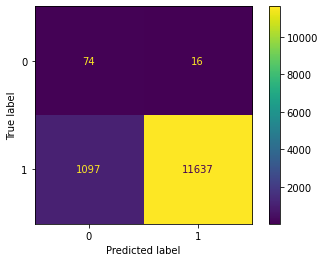

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#initialisation
best_params = 0
model = 0
accuracy = 0
i = 0
max = {'dataset': i, 'accuracy': accuracy, 'best_params': best_params}

for df in all_dfs:

  grid_params = {
      'n_neighbors' : [5, 7, 11, 19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(all_dfs[i]['x_train'], all_dfs[i]['y_train'])
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(all_dfs[i]['x_train'], all_dfs[i]['y_train'])
  y_test_hat = model.predict(X_test) 
  test_accuracy = accuracy_score(y_test,y_test_hat)*100
  if accuracy  < test_accuracy:
    accuracy = test_accuracy
    max = { 'dataset': i, 'accuracy': accuracy, 'best_params': best_params }
  print(i,test_accuracy)

  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print('roc',roc_auc_score(y_test,y_pred_proba))

  i = i + 1
  print('_______________________________________________')

print(max)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

✅ Conclusion: Best approach is smote-enn for our case

In [19]:
X_train.insert(0,'dates',pd.to_datetime(X_train['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train.drop('new_date', axis=1, inplace=True)
X_train.insert(len(X_train.columns),'label',y_train)

X_train_smote_tl_res.insert(0,'dates',pd.to_datetime(X_train_smote_tl_res['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train_smote_tl_res.drop('new_date', axis=1, inplace=True)
X_train_smote_tl_res.insert(len(X_train_smote_tl_res.columns),'label',y_train_smote_tl_res)

final = X_train.append(X_train_smote_tl_res, ignore_index=True)
final = final.sort_values(by="dates")

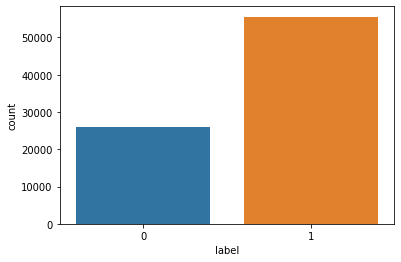

In [20]:
sns.countplot(x ='label', data = final)

In [21]:
print(final.groupby(['label']).size())

label
0    26102
1    55565
dtype: int64


In [22]:
final

,dates,temps_cycle,temps_dosage,temps_injection,pression_com,volume_com,matelas,val_pointe,integral,duration,pression,volume,label
42073,2022-01-02 17:43:00.000000000,23.770000,0.000000,3.570000,902,16.5,14.170000,1056,82,27.340000,1958,30.670000,0
13928,2022-01-02 17:43:00.000000000,23.770000,0.000000,3.570000,902,16.5,14.170000,1056,82,27.340000,1958,30.670000,0
56341,2022-01-02 17:43:03.946841344,23.769708,0.000000,3.569976,901,16.5,14.164007,1056,82,27.339683,1957,30.664007,0
76349,2022-01-02 17:43:25.321864704,23.768124,0.000000,3.569844,900,16.5,14.131548,1056,82,27.337968,1956,30.631548,0
15499,2022-01-02 17:44:00.000000000,27.040000,4.530000,3.550000,1317,16.5,16.260000,1333,125,35.120000,2650,32.760000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56221,2022-12-02 16:29:23.245705472,26.532102,3.562116,3.540000,1318,16.5,15.822232,1359,124,33.634218,2678,32.322232,0
65635,2022-12-02 16:34:19.540279552,26.672820,3.739106,3.540000,1343,16.5,15.988297,1374,127,33.951926,2717,32.488297,0
70763,2022-12-02 16:34:49.422718976,26.687012,3.756956,3.540000,1345,16.5,16.005045,1376,127,33.983968,2721,32.505045,0
458,2022-12-02 16:40:00.000000000,26.920000,4.250000,3.530000,1342,16.5,16.260000,1361,129,34.700000,2703,32.760000,1
